In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import VotingRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [3]:
# Load dataset
df = pd.read_csv("energydata_complete.csv")

In [4]:
# Convert date column to datetime with automatic format inference
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True, dayfirst=True)
df['hour'] = df['date'].dt.hour
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday
df['is_weekend'] = (df['weekday'] >= 5).astype(int)

<ipython-input-4-19c3f1e49694>:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True, dayfirst=True)


In [5]:
# Check if 'To' column exists, otherwise use an alternative name
if 'To' in df.columns:
    outdoor_temp_col = 'To'
elif 'T_out' in df.columns:
    outdoor_temp_col = 'T_out'
elif 'Outdoor_Temp' in df.columns:
    outdoor_temp_col = 'Outdoor_Temp'
else:
    outdoor_temp_col = None

In [6]:
# Create new features (Feature Engineering)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['temp_humidity_ratio'] = df['T1'] / (df['RH_1'] + 1e-5)  # Avoid division by zero
if outdoor_temp_col:
    df['outdoor_temp_variation'] = df[outdoor_temp_col] - df['T6']

In [7]:
# Check if 'Pressure' and 'RH_out' columns exist before creating interaction term
if 'Pressure' in df.columns and 'RH_out' in df.columns:
    df['pressure_humidity_interaction'] = df['Pressure'] * df['RH_out']

In [8]:
# Drop date column as it's now encoded
df.drop(columns=['date'], inplace=True)

In [8]:
# # Remove random variables (rv1, rv2) since they don't contribute to prediction
# df.drop(columns=['rv1', 'rv2'], inplace=True)

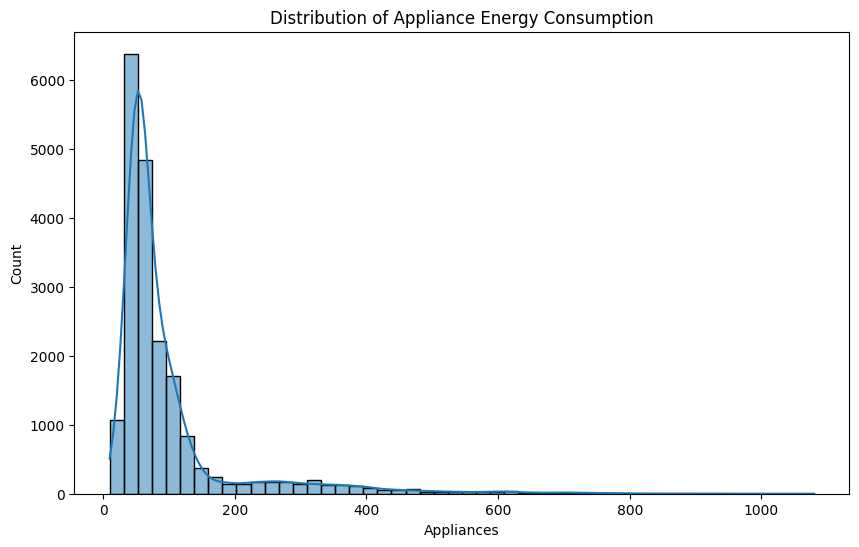

In [9]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(10, 6))
sns.histplot(df['Appliances'], bins=50, kde=True)
plt.title('Distribution of Appliance Energy Consumption')
plt.show()


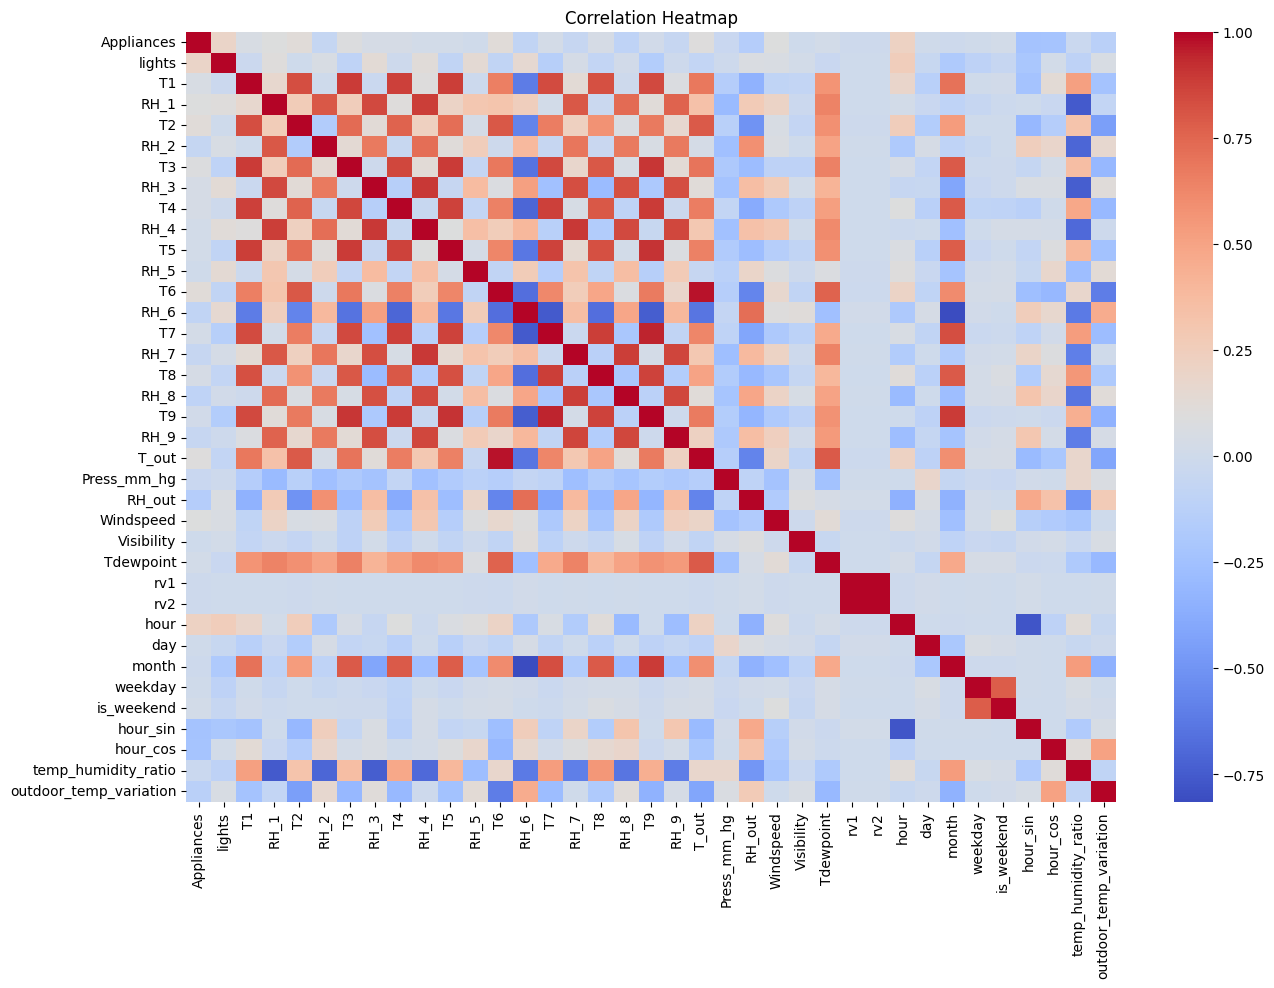

In [10]:
plt.figure(figsize=(15, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()

In [11]:
# Feature Selection (Remove weakly correlated features)
corr_threshold = 0.05
target = 'Appliances'
important_features = corr_matrix[target][abs(corr_matrix[target]) > corr_threshold].index.tolist()
X = df[important_features].drop(columns=[target])
y = df[target]


In [12]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
# Hyperparameter Tuning for Random Forest
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

In [15]:
# Train Gradient Boosting Regressor with tuned parameters
gbr = GradientBoostingRegressor(n_estimators=300, learning_rate=0.03, max_depth=6, random_state=42)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.03, max_depth=6, n_estimators=300,
                          random_state=42)

In [16]:
# Train XGBoost Regressor
xgb = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [17]:
# Ensemble Learning - Voting Regressor
ensemble = VotingRegressor(estimators=[('rf', best_rf), ('gbr', gbr), ('xgb', xgb)])
ensemble.fit(X_train, y_train)

VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(n_estimators=200,
                                                   random_state=42)),
                            ('gbr',
                             GradientBoostingRegressor(learning_rate=0.03,
                                                       max_depth=6,
                                                       n_estimators=300,
                                                       random_state=42)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_ro...
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.05, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=6,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=300,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=42, ...))])

In [18]:
# Train Neural Network Model
dnn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer
])

dnn.compile(optimizer='adam', loss='mse', metrics=['mse'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
# Train Neural Network
dnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=1)


Epoch 1/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 13013.1855 - mse: 13013.1855 - val_loss: 8308.2891 - val_mse: 8308.2891
Epoch 2/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8841.0088 - mse: 8841.0088 - val_loss: 8137.8574 - val_mse: 8137.8574
Epoch 3/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9463.4482 - mse: 9463.4482 - val_loss: 8023.2383 - val_mse: 8023.2383
Epoch 4/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 8420.9844 - mse: 8420.9844 - val_loss: 7922.9160 - val_mse: 7922.9160
Epoch 5/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8773.4248 - mse: 8773.4248 - val_loss: 7791.1123 - val_mse: 7791.1123
Epoch 6/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 8742.4600 - mse: 8742.4600 - val_loss: 7674.3892 - val_mse: 7674.3892
Epoch 7/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8168.3647 - mse: 8168.3647 - val_loss: 7675.5532 - val_mse: 7675.5532
Epoch 8/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8340.9492 - mse: 834

In [20]:
# Predictions
y_pred_rf = best_rf.predict(X_test)
y_pred_gbr = gbr.predict(X_test)
y_pred_xgb = xgb.predict(X_test)
y_pred_ensemble = ensemble.predict(X_test)
y_pred_dnn = dnn.predict(X_test).flatten()

124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [21]:
# Evaluate models
mse_rf = mean_squared_error(y_test, y_pred_rf)
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
mse_dnn = mean_squared_error(y_test, y_pred_dnn)

In [22]:
r2_rf = r2_score(y_test, y_pred_rf)
r2_gbr = r2_score(y_test, y_pred_gbr)
r2_xgb = r2_score(y_test, y_pred_xgb)
r2_ensemble = r2_score(y_test, y_pred_ensemble)
r2_dnn = r2_score(y_test, y_pred_dnn)

In [23]:
print(f'Optimized Random Forest MSE: {mse_rf}, R2: {r2_rf}')
print(f'Gradient Boosting MSE: {mse_gbr}, R2: {r2_gbr}')
print(f'XGBoost MSE: {mse_xgb}, R2: {r2_xgb}')
print(f'Ensemble Model MSE: {mse_ensemble}, R2: {r2_ensemble}')
print(f'Neural Network MSE: {mse_dnn}, R2: {r2_dnn}')

Optimized Random Forest MSE: 4405.096644920193, R2: 0.5598024837073896
Gradient Boosting MSE: 5744.582581520598, R2: 0.4259488069485994
XGBoost MSE: 5264.7392578125, R2: 0.47389906644821167
Ensemble Model MSE: 4906.551237411746, R2: 0.5096925578779863
Neural Network MSE: 6438.02490234375, R2: 0.35665363073349


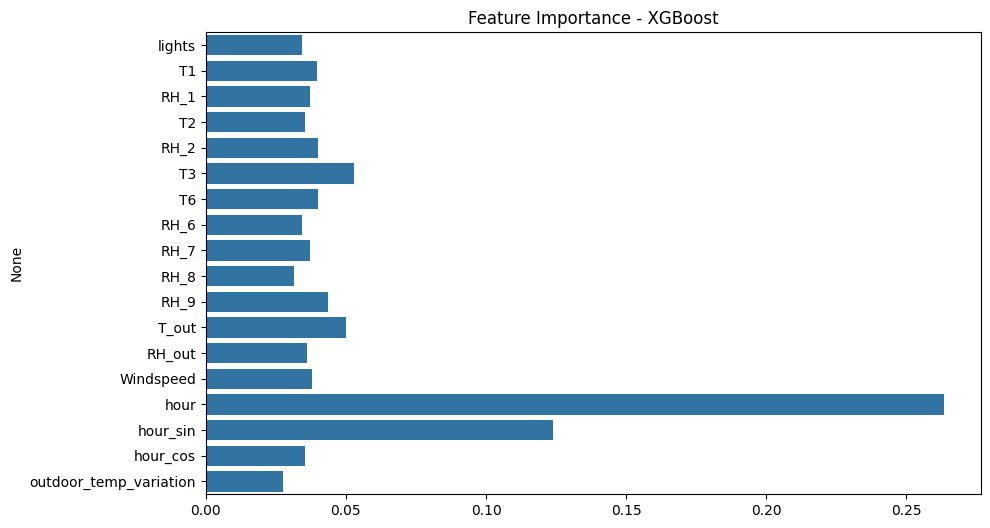

In [24]:
# Feature Importance from XGBoost
feature_importance = xgb.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_names)
plt.title('Feature Importance - XGBoost')
plt.show()